# Mediplexis - Progressive Random Forest Model

In [1]:
import os
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
print(os.listdir())

['.ipynb_checkpoints', '2018_datathon', 'Clean.ipynb', 'demog.csv', 'Go1-Copy1.ipynb', 'Go1-Copy2.ipynb', 'Go1-Copy3.ipynb', 'Go1.ipynb', 'ProgRanForSub.csv', 'Progressive Random Forest.ipynb', 'Random Forest - Hyper Parameter Tuning.ipynb', 'Random Forest Without Tuning-Copy1.ipynb', 'Random Forest Without Tuning.ipynb', 'RanForSub.csv', 'sateesh_sivakoti.rar', 'sateesh_sivakoti_14121996.csv', 'submission.csv', 'train.csv', 'Untitled.ipynb', 'workbook.xlsx']


In [3]:
train_data = pd.read_csv('train.csv')
demog  = pd.read_csv('demog.csv')

In [4]:
train_data.head()

,HCP_ID,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM,Region,Value,Speciality_ID
0,9304,0.645833,0.475755,NaN,NaN,0.0,0.169355,NaN,0.004458,urban,H,307999
1,9305,0.419355,0.190302,NaN,0.115167,0.0,0.012195,NaN,0.000000,urban,H,307999
2,9306,1.000000,NaN,NaN,0.134362,0.0,0.149254,0.129584,0.113179,urban,L,307999
3,9307,0.564102,NaN,0.054703,0.076778,NaN,0.138889,0.158047,0.002574,urban,H,307999
4,9308,0.584906,NaN,0.145874,0.383891,0.0,0.198198,0.125850,0.044009,urban,H,307999


In [5]:
train_data['Speciality_ID'] = train_data['Speciality_ID'].astype('category')

In [6]:
print('Number of specialities:',len(train_data['Speciality_ID'].unique()))

Number of specialities: 16


In [7]:
train_data['Speciality_ID'].value_counts()

155443    27110
92938      1972
569454     1793
295159     1672
96835      1435
483435      830
321702      593
462171      495
262386      357
333055      335
18766       266
334432      167
371651      114
307999       41
306909        3
117101        3
Name: Speciality_ID, dtype: int64

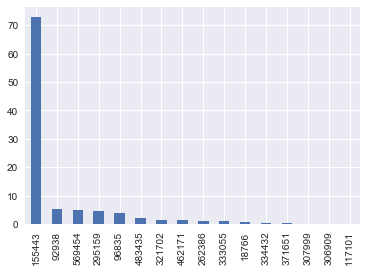

In [8]:
(train_data['Speciality_ID'].value_counts()*100/len(train_data)).plot(kind='bar')

** Over 70% of the physicians specialise in 155443 of the 16 specialisations**

In [9]:
train_data.describe()

,HCP_ID,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM
count,37186.000000,32337.000000,8050.000000,20159.000000,27538.000000,32694.000000,32807.000000,26016.000000,26146.000000
mean,27910.118297,0.601944,0.189566,0.155577,0.221124,0.036384,0.118864,0.192901,0.072392
std,10741.107350,0.184662,0.179546,0.191303,0.197190,0.095047,0.174413,0.113425,0.088854
min,9304.000000,0.022727,0.024893,0.017238,0.002376,0.000000,0.000000,0.000000,0.000000
25%,18612.250000,0.491228,0.068771,0.034476,0.068164,0.000000,0.010101,0.109769,0.000000
50%,27910.500000,0.630435,0.137542,0.086190,0.163704,0.000000,0.058642,0.185038,0.046951
75%,37210.750000,0.740000,0.208524,0.189618,0.313554,0.022222,0.145299,0.263858,0.104650
max,46513.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
print('Number of samples:',len(train_data))
print('Null Values:')
print(train_data.isnull().sum())

Number of samples: 37186
Null Values:
HCP_ID               0
RL                4849
P2P              29136
OLV              17027
RR                9648
DRT               4492
DMS               4379
OLA              11170
DEM              11040
Region               0
Value                0
Speciality_ID        0
dtype: int64


In [11]:
demog.head()

,HCP_ID,gender,Age
0,14586,FEMALE,34
1,46157,MALE,34
2,16600,MALE,34
3,16601,MALE,33
4,16602,FEMALE,33


In [12]:
demog.describe()

,HCP_ID,Age
count,46485.000000,46485.000000
mean,23257.437883,81.938238
std,13427.684933,32.947070
min,1.000000,22.000000
25%,11627.000000,52.000000
50%,23260.000000,89.000000
75%,34884.000000,110.000000
max,46513.000000,121.000000


In [13]:
print('Length of demographic data set:',len(demog))
print('Null Values:')
print(demog.isnull().sum())

Length of demographic data set: 46485
Null Values:
HCP_ID     0
gender    31
Age        0
dtype: int64


In [14]:
missing_IDs = list(set(train_data['HCP_ID']) - set(demog['HCP_ID']))
missing_IDs

[]

** We have demographic data for all the physicians present in the training set.**

In [15]:
set(list(demog[demog['gender'].isnull()]['HCP_ID'])) - set(list(train_data['HCP_ID']))

{3183, 4095, 7804}

** And the gender of (31-3) physicians from the training set is not available.**

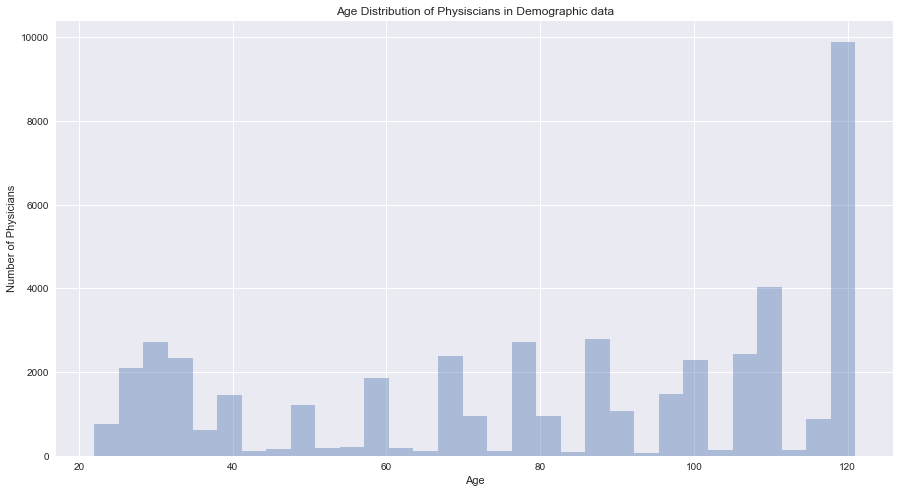

In [16]:
plt.figure(figsize=(15,8))
sns.distplot(demog['Age'], kde = False)
plt.ylabel('Number of Physicians')
plt.title('Age Distribution of Physiscians in Demographic data')
plt.show()

**Merging the training and demographic dataset.**

In [17]:
train_merge  = train_data.merge(demog, on='HCP_ID', how='left')
train_merge.head()

,HCP_ID,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM,Region,Value,Speciality_ID,gender,Age
0,9304,0.645833,0.475755,NaN,NaN,0.0,0.169355,NaN,0.004458,urban,H,307999,MALE,120
1,9305,0.419355,0.190302,NaN,0.115167,0.0,0.012195,NaN,0.000000,urban,H,307999,FEMALE,29
2,9306,1.000000,NaN,NaN,0.134362,0.0,0.149254,0.129584,0.113179,urban,L,307999,MALE,32
3,9307,0.564102,NaN,0.054703,0.076778,NaN,0.138889,0.158047,0.002574,urban,H,307999,MALE,60
4,9308,0.584906,NaN,0.145874,0.383891,0.0,0.198198,0.125850,0.044009,urban,H,307999,FEMALE,110


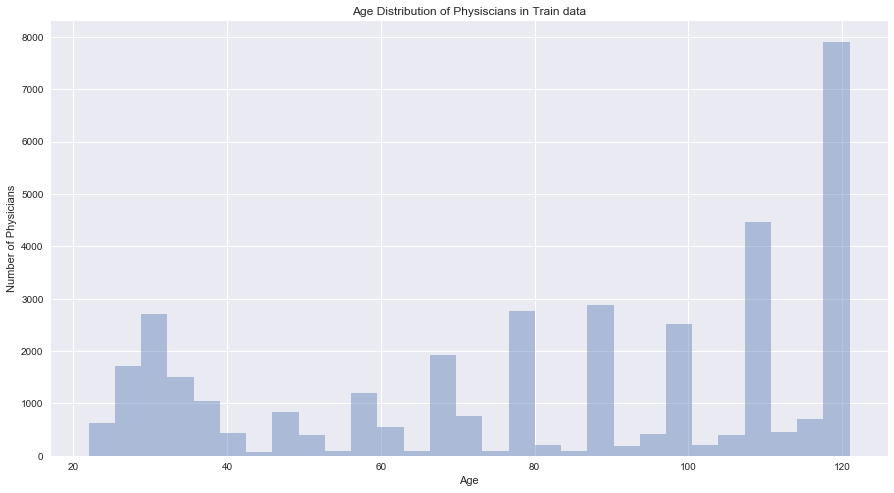

In [18]:
plt.figure(figsize=(15,8))
sns.distplot(train_merge['Age'], kde = False)
plt.ylabel('Number of Physicians')
plt.title('Age Distribution of Physiscians in Train data')
plt.show()

## Looking at the missing Values

In [19]:
train_merge.isnull().sum()

HCP_ID               0
RL                4849
P2P              29136
OLV              17027
RR                9648
DRT               4492
DMS               4379
OLA              11170
DEM              11040
Region               0
Value                0
Speciality_ID        0
gender              28
Age                  0
dtype: int64

In [20]:
train_merge['gender'].value_counts()

MALE      27233
FEMALE     9925
Name: gender, dtype: int64

In [21]:
train_merge['gender'].fillna(value = 'MALE', inplace = True)

## Correlation

In [22]:
train_merge.corr()

,HCP_ID,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM,Age
HCP_ID,1.000000,0.122781,0.099278,-0.041475,0.130615,0.019747,-0.045423,0.139983,0.024821,-0.026619
RL,0.122781,1.000000,0.175796,0.114087,0.187633,0.051000,0.047266,0.427631,0.067490,0.033513
P2P,0.099278,0.175796,1.000000,0.077611,0.105060,0.050451,0.014823,0.406466,0.066068,0.042631
OLV,-0.041475,0.114087,0.077611,1.000000,0.137273,0.114160,0.067476,0.083013,0.417225,0.039938
RR,0.130615,0.187633,0.105060,0.137273,1.000000,0.027704,0.006780,0.367050,0.040394,0.011547
DRT,0.019747,0.051000,0.050451,0.114160,0.027704,1.000000,0.012577,0.050025,0.413419,0.005574
DMS,-0.045423,0.047266,0.014823,0.067476,0.006780,0.012577,1.000000,0.004709,0.552483,0.052023
OLA,0.139983,0.427631,0.406466,0.083013,0.367050,0.050025,0.004709,1.000000,0.034400,-0.267539
DEM,0.024821,0.067490,0.066068,0.417225,0.040394,0.413419,0.552483,0.034400,1.000000,0.062406
Age,-0.026619,0.033513,0.042631,0.039938,0.011547,0.005574,0.052023,-0.267539,0.062406,1.000000


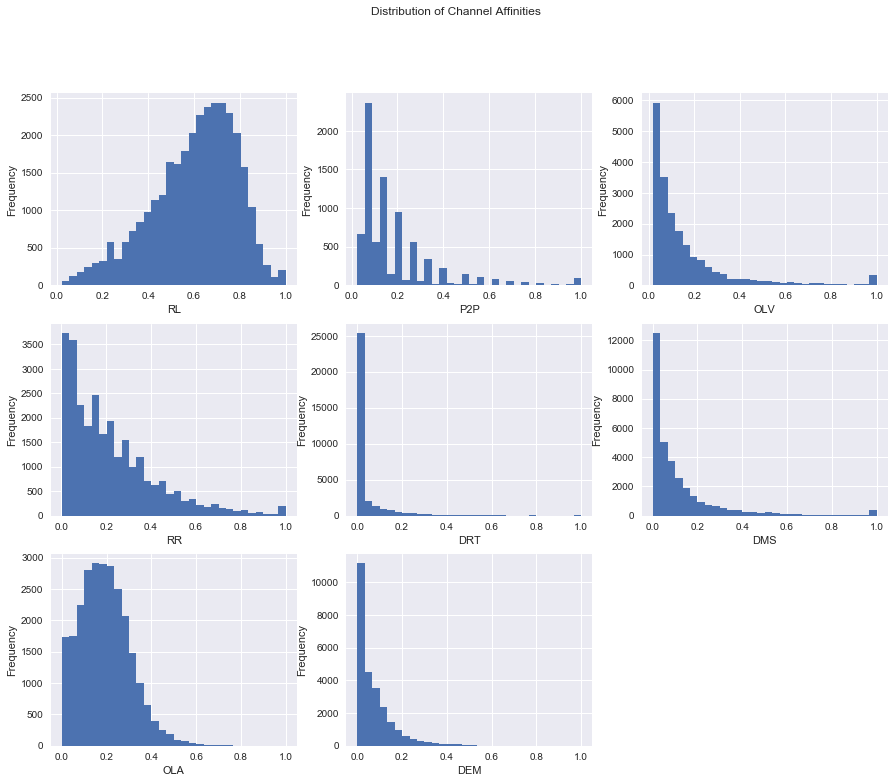

In [23]:
plt.figure(figsize=(15,12))
count = 0
for channel in train_merge.columns[1:9]:
    count = count + 1
    plt.subplot(3,3,count)
    train_merge[channel].plot.hist(bins = 30)
    plt.xlabel(channel)
plt.suptitle('Distribution of Channel Affinities')    
plt.show()

**Those low correlations MAY be due to the highly skewed nature of the data**

https://stats.stackexchange.com/questions/127121/do-logs-modify-the-correlation-between-two-variables

Logarithm being a non-linear transformation wil effect the correlation.

** With the correlations being so low, I have decided against using a linear model. I will move to a tree based model.**

* For building a better tree based model, we need to identify/engineer features which give us more information.
* Constructing tables for each categorical feature and examining the mean channel affinity..

In [24]:
table1 = train_merge.pivot_table(index = 'Speciality_ID',values = train_merge.columns[1:9], aggfunc=np.mean)
table1

,DEM,DMS,DRT,OLA,OLV,P2P,RL,RR
Speciality_ID,,,,,,,,
18766,0.060208,0.131931,0.027415,0.158664,0.130546,0.121324,0.437301,0.222246
92938,0.071102,0.185470,0.024853,0.129819,0.113292,0.130959,0.569128,0.064231
96835,0.056340,0.118485,0.035474,0.185836,0.112300,0.224556,0.708149,0.277730
117101,0.054027,0.194862,0.066667,0.197337,0.096061,NaN,0.484905,0.166377
155443,0.076864,0.115966,0.037604,0.202617,0.151430,0.203887,0.600631,0.229430
262386,0.058471,0.073590,0.071381,0.214337,0.145929,0.136699,0.663752,0.371657
295159,0.050746,0.089817,0.007728,0.143719,0.203619,0.117136,0.450069,0.156658
306909,0.054520,0.000000,0.125000,0.344001,NaN,0.412233,0.884615,0.344512
307999,0.064981,0.126084,0.046607,0.135333,0.077735,0.179730,0.673499,0.168799


In [25]:
table2 = train_merge.pivot_table(index = 'Value',values = train_merge.columns[1:9], aggfunc=np.mean)
table2

,DEM,DMS,DRT,OLA,OLV,P2P,RL,RR
Value,,,,,,,,
H,0.077047,0.129570,0.037734,0.203506,0.170514,0.206122,0.653498,0.246436
L,0.059185,0.097030,0.030601,0.148612,0.109343,0.153728,0.436436,0.144170
M,0.064835,0.100092,0.034336,0.176886,0.131622,0.161028,0.519504,0.180303
U,0.060348,0.134810,0.031801,0.136945,0.061220,0.174909,0.461006,0.096118


In [26]:
table3 = train_merge.pivot_table(index = 'Region',values = train_merge.columns[1:9], aggfunc=np.mean)
table3

,DEM,DMS,DRT,OLA,OLV,P2P,RL,RR
Region,,,,,,,,
rural,0.078747,0.122264,0.040499,0.15832,0.156232,0.168646,0.585347,0.230967
urban,0.071349,0.118300,0.035700,0.19864,0.155468,0.193095,0.604721,0.219508


In [27]:
table4 = train_merge.pivot_table(index = ['Region', 'Value'],values = train_merge.columns[1:9], aggfunc=np.mean)
table4

DEM       DMS       DRT       OLA       OLV       P2P  \
Region Value                                                               
rural  H      0.084280  0.136965  0.042496  0.164176  0.170412  0.180540   
       L      0.060776  0.082897  0.043756  0.139067  0.083780  0.117106   
       M      0.068929  0.094305  0.035587  0.148120  0.132311  0.147272   
       U      0.042441  0.065607  0.080667  0.083796  0.052546  0.165057   
urban  H      0.075802  0.128277  0.036905  0.210382  0.170531  0.210661   
       L      0.058933  0.099314  0.028447  0.150213  0.113733  0.159672   
       M      0.064220  0.100959  0.034146  0.181179  0.131519  0.163120   
       U      0.062658  0.144696  0.025347  0.145691  0.062150  0.177502   

                    RL        RR  
Region Value                      
rural  H      0.639082  0.253168  
       L      0.446177  0.133080  
       M      0.485431  0.191645  
       U      0.363553  0.100350  
urban  H      0.656023  0.245270  
       L      0.434888  0.145826  
       M      0.524749  0.178615  
       U      0.472419  0.095606

In [28]:
table5 = train_merge.pivot_table(index = 'gender',values = train_merge.columns[1:9], aggfunc=np.mean)
table5

,DEM,DMS,DRT,OLA,OLV,P2P,RL,RR
gender,,,,,,,,
FEMALE,0.063431,0.099733,0.033292,0.178695,0.125214,0.173823,0.574150,0.209053
MALE,0.075675,0.125854,0.037516,0.198099,0.166639,0.195475,0.612052,0.225492


* ** Combining Region and Value rather than looking at them independently gives more information.**

** How to factor in age?**

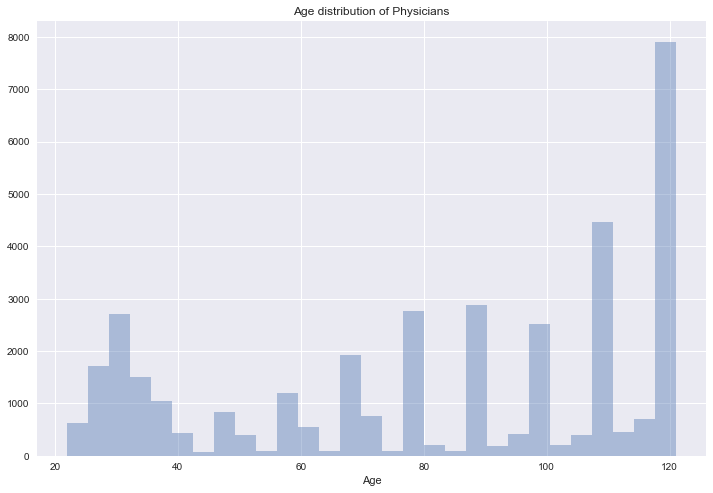

In [29]:
plt.figure(figsize=(12,8))
sns.distplot(train_merge['Age'], kde = False)
plt.title('Age distribution of Physicians')
plt.show()

* **Want to divide the age data into groups so that it can be used more effectively**
* **Converting age data into a binary variable by examining from which age there is a stark contrast in mean channel affininty.**

In [30]:
for channel in train_merge.columns[1:9]:
    print('###############',channel,'##################')
    for age in range(30, 115, 5):
        ageRange = train_merge[train_merge['Age']>=age][train_merge['Age']<age+5]
        print('age:',age,'-',age+5, ':',ageRange[channel].mean())

############### RL ##################
age: 30 - 35 : 0.5987055535554071
age: 35 - 40 : 0.5901647078500476
age: 40 - 45 : 0.6047662863868777
age: 45 - 50 : 0.5925236530982271
age: 50 - 55 : 0.5966350020256403
age: 55 - 60 : 0.5938282267181396
age: 60 - 65 : 0.5832345726468331
age: 65 - 70 : 0.6029614190571433
age: 70 - 75 : 0.5969338719592435
age: 75 - 80 : 0.6041751701658984
age: 80 - 85 : 0.5906174486526162
age: 85 - 90 : 0.5991719612636703
age: 90 - 95 : 0.5891126868876267
age: 95 - 100 : 0.6061322449408824
age: 100 - 105 : 0.586476621504854
age: 105 - 110 : 0.6100447963796759
age: 110 - 115 : 0.601649500995743
############### P2P ##################
age: 30 - 35 : 0.19363559142896572
age: 35 - 40 : 0.19037567819011403
age: 40 - 45 : 0.18929219223300978
age: 45 - 50 : 0.17032030951020413
age: 50 - 55 : 0.23120865268674703
age: 55 - 60 : 0.16911034606415087
age: 60 - 65 : 0.1931667137822581
age: 65 - 70 : 0.17652235761047821
age: 70 - 75 : 0.18835106203821658
age: 75 - 80 : 0.176050687

** Conclusions:**
* **E-mail** - Above 65 have high affinity (1)
* **OLA** - Less than 65 have high affinity (1)
* **DMS** - (40-45) and 65+ have high affinity (1)
* **OLV** - 85+ have high affinity (1)

In [31]:
train_merge.head()

,HCP_ID,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM,Region,Value,Speciality_ID,gender,Age
0,9304,0.645833,0.475755,NaN,NaN,0.0,0.169355,NaN,0.004458,urban,H,307999,MALE,120
1,9305,0.419355,0.190302,NaN,0.115167,0.0,0.012195,NaN,0.000000,urban,H,307999,FEMALE,29
2,9306,1.000000,NaN,NaN,0.134362,0.0,0.149254,0.129584,0.113179,urban,L,307999,MALE,32
3,9307,0.564102,NaN,0.054703,0.076778,NaN,0.138889,0.158047,0.002574,urban,H,307999,MALE,60
4,9308,0.584906,NaN,0.145874,0.383891,0.0,0.198198,0.125850,0.044009,urban,H,307999,FEMALE,110


In [32]:
def createRegVal(row):
    return row[9]+'-'+row[10]

In [33]:
training = train_merge.copy()
training['Reg_Value'] = training.apply(createRegVal, axis = 1)
training['Reg_Value'] = training['Reg_Value'].astype('category')
training.head()

,HCP_ID,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM,Region,Value,Speciality_ID,gender,Age,Reg_Value
0,9304,0.645833,0.475755,NaN,NaN,0.0,0.169355,NaN,0.004458,urban,H,307999,MALE,120,urban-H
1,9305,0.419355,0.190302,NaN,0.115167,0.0,0.012195,NaN,0.000000,urban,H,307999,FEMALE,29,urban-H
2,9306,1.000000,NaN,NaN,0.134362,0.0,0.149254,0.129584,0.113179,urban,L,307999,MALE,32,urban-L
3,9307,0.564102,NaN,0.054703,0.076778,NaN,0.138889,0.158047,0.002574,urban,H,307999,MALE,60,urban-H
4,9308,0.584906,NaN,0.145874,0.383891,0.0,0.198198,0.125850,0.044009,urban,H,307999,FEMALE,110,urban-H


In [34]:
training_rem = training.copy()

# Setting up validation

* **To cross validate the progressive model, we will need a validation training and test set.**
* **But, there is no row without missing values. So validating the prediction of the affinities of a channel from another channel is not straightforward as we don't have actual values to validate  with.**
* **First, we will identify all the non-NaN rows of DMS as it has the least missing values. Use these indices across to pick out the validation rows/samples for all the other channels.**

In [35]:
validation_df = training_rem[~training_rem['DMS'].isnull()]
validation_df.head()

,HCP_ID,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM,Region,Value,Speciality_ID,gender,Age,Reg_Value
0,9304,0.645833,0.475755,NaN,NaN,0.0,0.169355,NaN,0.004458,urban,H,307999,MALE,120,urban-H
1,9305,0.419355,0.190302,NaN,0.115167,0.0,0.012195,NaN,0.000000,urban,H,307999,FEMALE,29,urban-H
2,9306,1.000000,NaN,NaN,0.134362,0.0,0.149254,0.129584,0.113179,urban,L,307999,MALE,32,urban-L
3,9307,0.564102,NaN,0.054703,0.076778,NaN,0.138889,0.158047,0.002574,urban,H,307999,MALE,60,urban-H
4,9308,0.584906,NaN,0.145874,0.383891,0.0,0.198198,0.125850,0.044009,urban,H,307999,FEMALE,110,urban-H


In [36]:
validation_df.isnull().sum().sort_values()

HCP_ID               0
DMS                  0
Region               0
Value                0
Speciality_ID        0
gender               0
Age                  0
Reg_Value            0
DRT               3948
RL                4280
RR                8555
DEM               9746
OLA               9858
OLV              15048
P2P              25670
dtype: int64

In [37]:
validation_df['Age'] = validation_df.apply(lambda row: int(row[-2]>=65), axis = 1)
validation_df['Age'] = validation_df['Age'].astype('category')
validation_df.head()

,HCP_ID,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM,Region,Value,Speciality_ID,gender,Age,Reg_Value
0,9304,0.645833,0.475755,NaN,NaN,0.0,0.169355,NaN,0.004458,urban,H,307999,MALE,1,urban-H
1,9305,0.419355,0.190302,NaN,0.115167,0.0,0.012195,NaN,0.000000,urban,H,307999,FEMALE,0,urban-H
2,9306,1.000000,NaN,NaN,0.134362,0.0,0.149254,0.129584,0.113179,urban,L,307999,MALE,0,urban-L
3,9307,0.564102,NaN,0.054703,0.076778,NaN,0.138889,0.158047,0.002574,urban,H,307999,MALE,0,urban-H
4,9308,0.584906,NaN,0.145874,0.383891,0.0,0.198198,0.125850,0.044009,urban,H,307999,FEMALE,1,urban-H


In [38]:
validation_df['Reg_Value'] = validation_df['Reg_Value'].astype('category')
validation_df.drop(['HCP_ID', 'Region', 'Value'], axis = 1, inplace = True)
validation_df.head()

,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM,Speciality_ID,gender,Age,Reg_Value
0,0.645833,0.475755,NaN,NaN,0.0,0.169355,NaN,0.004458,307999,MALE,1,urban-H
1,0.419355,0.190302,NaN,0.115167,0.0,0.012195,NaN,0.000000,307999,FEMALE,0,urban-H
2,1.000000,NaN,NaN,0.134362,0.0,0.149254,0.129584,0.113179,307999,MALE,0,urban-L
3,0.564102,NaN,0.054703,0.076778,NaN,0.138889,0.158047,0.002574,307999,MALE,0,urban-H
4,0.584906,NaN,0.145874,0.383891,0.0,0.198198,0.125850,0.044009,307999,FEMALE,1,urban-H


**Will shuffle the rows.**

In [39]:
shuffle_df = validation_df.sample(frac = 1, random_state = 42)
shuffle_df.head()

,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM,Speciality_ID,gender,Age,Reg_Value
33559,0.684210,0.137542,NaN,NaN,0.000000,0.014286,NaN,0.035949,155443,MALE,0,urban-M
20527,NaN,NaN,0.068952,0.490780,NaN,0.085106,0.267542,0.058326,155443,MALE,1,urban-H
32889,0.583333,NaN,0.017238,NaN,0.113208,0.000000,0.213543,0.001581,155443,FEMALE,1,urban-M
10724,0.779069,NaN,NaN,0.081797,0.012346,0.339286,0.272561,NaN,155443,MALE,0,urban-H
27619,NaN,0.756479,0.017238,0.136328,0.000000,0.088000,0.280795,NaN,155443,MALE,1,rural-H


In [40]:
shuffle_df.reset_index(drop = True, inplace=True)

**Need to fill in the missing values for validating the model.**

In [41]:
descript_stats = training_rem.describe()
descript_stats

,HCP_ID,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM,Age
count,37186.000000,32337.000000,8050.000000,20159.000000,27538.000000,32694.000000,32807.000000,26016.000000,26146.000000,37186.000000
mean,27910.118297,0.601944,0.189566,0.155577,0.221124,0.036384,0.118864,0.192901,0.072392,81.882160
std,10741.107350,0.184662,0.179546,0.191303,0.197190,0.095047,0.174413,0.113425,0.088854,32.953314
min,9304.000000,0.022727,0.024893,0.017238,0.002376,0.000000,0.000000,0.000000,0.000000,22.000000
25%,18612.250000,0.491228,0.068771,0.034476,0.068164,0.000000,0.010101,0.109769,0.000000,52.000000
50%,27910.500000,0.630435,0.137542,0.086190,0.163704,0.000000,0.058642,0.185038,0.046951,89.000000
75%,37210.750000,0.740000,0.208524,0.189618,0.313554,0.022222,0.145299,0.263858,0.104650,110.000000
max,46513.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,121.000000


In [42]:
for channel in descript_stats.columns[1:9]:
    shuffle_df[channel] = shuffle_df[channel].fillna(value = descript_stats.loc['mean', channel])

In [43]:
shuffle_df.isnull().sum()

RL               0
P2P              0
OLV              0
RR               0
DRT              0
DMS              0
OLA              0
DEM              0
Speciality_ID    0
gender           0
Age              0
Reg_Value        0
dtype: int64

In [44]:
shuffle_rl = shuffle_df['RL']
shuffle_p2p = shuffle_df['P2P']
shuffle_olv = shuffle_df['OLV']
shuffle_rr = shuffle_df['RR']
shuffle_drt = shuffle_df['DRT']
shuffle_dms = shuffle_df['DMS']
shuffle_ola = shuffle_df['OLA']
shuffle_email = shuffle_df['DEM']

In [45]:
training_rem.isnull().sum().sort_values()

HCP_ID               0
Region               0
Value                0
Speciality_ID        0
gender               0
Age                  0
Reg_Value            0
DMS               4379
DRT               4492
RL                4849
RR                9648
DEM              11040
OLA              11170
OLV              17027
P2P              29136
dtype: int64

In [46]:
channel_order = training_rem.isnull().sum().sort_values().index[-8:].tolist()
shuffle_sets = [shuffle_dms,shuffle_drt,shuffle_rl,shuffle_rr,shuffle_email,shuffle_ola,shuffle_olv,shuffle_p2p]

In [47]:
channel_order

['DMS', 'DRT', 'RL', 'RR', 'DEM', 'OLA', 'OLV', 'P2P']

In [48]:
shuffle_rl.head()

0    0.684210
1    0.601944
2    0.583333
3    0.779069
4    0.601944
Name: RL, dtype: float64

In [49]:
common_df = shuffle_df[shuffle_df.columns[-4:]]
common_df.head()

,Speciality_ID,gender,Age,Reg_Value
0,155443,MALE,0,urban-M
1,155443,MALE,1,urban-H
2,155443,FEMALE,1,urban-M
3,155443,MALE,0,urban-H
4,155443,MALE,1,rural-H


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [51]:
train_df = common_df.copy()
predictions, actual = [], []
count = 0
for target_data in shuffle_sets:
    print(count,',',channel_order[count])
    val_train_X, val_test_X, val_train_Y, val_test_Y = train_test_split(train_df, \
                                                                        target_data ,test_size=0.33,\
                                                                        random_state=(42+count))
    
    val_train_X = pd.get_dummies(val_train_X)
    val_test_X = pd.get_dummies(val_test_X)
    model = RandomForestRegressor(n_estimators=60, max_depth = 15, min_samples_split=15, random_state=42)
    model.fit(val_train_X, val_train_Y)
    predict_now = list(model.predict(val_test_X))
    predictions.extend(predict_now)
    actual.extend(val_test_Y)
    train_df[channel_order[count]] = target_data
    train_df.loc[val_test_X.index.tolist(), channel_order[count]] = predict_now
    count = count+1

0 , DMS
1 , DRT
2 , RL
3 , RR
4 , DEM
5 , OLA
6 , OLV
7 , P2P


In [52]:
def compute_rmse(predictions, actual):
    size = len(predictions)
    numer = 0
    for i in range(size):
        numer = numer + (predictions[i]-actual[i])**2
    return np.sqrt(numer/size)

In [53]:
rmse = compute_rmse(predictions, actual)
print('Cross Validation RMSE:', rmse)

Cross Validation RMSE: 0.125943975403


# Prediction

In [54]:
channel_order

['DMS', 'DRT', 'RL', 'RR', 'DEM', 'OLA', 'OLV', 'P2P']

In [55]:
dataset = training_rem.copy()
dataset.head()

,HCP_ID,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM,Region,Value,Speciality_ID,gender,Age,Reg_Value
0,9304,0.645833,0.475755,NaN,NaN,0.0,0.169355,NaN,0.004458,urban,H,307999,MALE,120,urban-H
1,9305,0.419355,0.190302,NaN,0.115167,0.0,0.012195,NaN,0.000000,urban,H,307999,FEMALE,29,urban-H
2,9306,1.000000,NaN,NaN,0.134362,0.0,0.149254,0.129584,0.113179,urban,L,307999,MALE,32,urban-L
3,9307,0.564102,NaN,0.054703,0.076778,NaN,0.138889,0.158047,0.002574,urban,H,307999,MALE,60,urban-H
4,9308,0.584906,NaN,0.145874,0.383891,0.0,0.198198,0.125850,0.044009,urban,H,307999,FEMALE,110,urban-H


In [56]:
dataset['Age'] = dataset.apply(lambda row: int(row[-2]>=65), axis = 1)
dataset['Age'] = dataset['Age'].astype('category')
dataset.head()

,HCP_ID,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM,Region,Value,Speciality_ID,gender,Age,Reg_Value
0,9304,0.645833,0.475755,NaN,NaN,0.0,0.169355,NaN,0.004458,urban,H,307999,MALE,1,urban-H
1,9305,0.419355,0.190302,NaN,0.115167,0.0,0.012195,NaN,0.000000,urban,H,307999,FEMALE,0,urban-H
2,9306,1.000000,NaN,NaN,0.134362,0.0,0.149254,0.129584,0.113179,urban,L,307999,MALE,0,urban-L
3,9307,0.564102,NaN,0.054703,0.076778,NaN,0.138889,0.158047,0.002574,urban,H,307999,MALE,0,urban-H
4,9308,0.584906,NaN,0.145874,0.383891,0.0,0.198198,0.125850,0.044009,urban,H,307999,FEMALE,1,urban-H


In [57]:
dataset['Reg_Value'] = dataset['Reg_Value'].astype('category')
dataset.drop(['HCP_ID', 'Region', 'Value'], axis = 1, inplace = True)
dataset.head()

,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM,Speciality_ID,gender,Age,Reg_Value
0,0.645833,0.475755,NaN,NaN,0.0,0.169355,NaN,0.004458,307999,MALE,1,urban-H
1,0.419355,0.190302,NaN,0.115167,0.0,0.012195,NaN,0.000000,307999,FEMALE,0,urban-H
2,1.000000,NaN,NaN,0.134362,0.0,0.149254,0.129584,0.113179,307999,MALE,0,urban-L
3,0.564102,NaN,0.054703,0.076778,NaN,0.138889,0.158047,0.002574,307999,MALE,0,urban-H
4,0.584906,NaN,0.145874,0.383891,0.0,0.198198,0.125850,0.044009,307999,FEMALE,1,urban-H


In [58]:
common_data = dataset[dataset.columns[-4:]]
common_data.head()

,Speciality_ID,gender,Age,Reg_Value
0,307999,MALE,1,urban-H
1,307999,FEMALE,0,urban-H
2,307999,MALE,0,urban-L
3,307999,MALE,0,urban-H
4,307999,FEMALE,1,urban-H


In [59]:
target_columns = []
for channel in channel_order:
    target_columns.append(dataset[channel])

In [60]:
train_dataset = common_data.copy()
count = 0
for target_column in target_columns:
    print(count,',',channel_order[count])
    test_indices = target_column[target_column.isnull()].index.tolist()
    train_indices = list(set(target_column.index.tolist()) - set(test_indices))
    train_X = train_dataset.iloc[train_indices]
    train_Y = target_column[train_indices]
    test_X = train_dataset.iloc[test_indices]
    
    train_X = pd.get_dummies(train_X)
    test_X = pd.get_dummies(test_X)
    
    model = RandomForestRegressor(n_estimators=60, max_depth = 15, min_samples_split=15, random_state=42)
    model.fit(train_X, train_Y)
    predict_now = list(model.predict(test_X))
    
    train_dataset[channel_order[count]] = target_column
    train_dataset.loc[test_indices, channel_order[count]] = predict_now
    count = count+1
    
    feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = train_X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
    print(feature_importances)

0 , DMS
                      importance
Speciality_ID_92938     0.207910
Reg_Value_urban-M       0.139219
gender_FEMALE           0.061737
Reg_Value_rural-M       0.047261
Speciality_ID_295159    0.046586
Age_1                   0.046493
Age_0                   0.043555
Speciality_ID_462171    0.037306
Speciality_ID_483435    0.036770
Speciality_ID_155443    0.034975
Reg_Value_urban-L       0.032445
Speciality_ID_569454    0.030366
Reg_Value_rural-H       0.028941
Speciality_ID_321702    0.024002
Speciality_ID_262386    0.023485
Speciality_ID_96835     0.023179
gender_MALE             0.021360
Reg_Value_urban-H       0.020365
Speciality_ID_18766     0.020011
Speciality_ID_371651    0.019054
Reg_Value_urban-U       0.013435
Speciality_ID_333055    0.013117
Reg_Value_rural-L       0.011530
Speciality_ID_334432    0.006180
Speciality_ID_307999    0.005101
Speciality_ID_117101    0.003404
Reg_Value_rural-U       0.001834
Speciality_ID_306909    0.000379
1 , DRT
                      impor

In [61]:
sub = pd.read_csv('submission.csv')

In [62]:
submission = sub.copy()
submission.head()

,HCP_ID,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM
0,9304,0.645833,0.475755,NaN,NaN,0.0,0.169355,NaN,0.004458
1,9305,0.419355,0.190302,NaN,0.115167,0.0,0.012195,NaN,0.000000
2,9306,1.000000,NaN,NaN,0.134362,0.0,0.149254,0.129584,0.113179
3,9307,0.564102,NaN,0.054703,0.076778,NaN,0.138889,0.158047,0.002574
4,9308,0.584906,NaN,0.145874,0.383891,0.0,0.198198,0.125850,0.044009


**Comparing the descriptive statistics of the imputed dataset with the original**

In [63]:
for channel in channel_order:
    submission[channel] = train_dataset[channel]
    
submission.describe()

,HCP_ID,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM
count,37186.000000,37186.000000,37186.000000,37186.000000,37186.000000,37186.000000,37186.000000,37186.000000,37186.000000
mean,27910.118297,0.602073,0.194953,0.156548,0.220993,0.036410,0.118909,0.193151,0.072919
std,10741.107350,0.175792,0.117471,0.157152,0.173118,0.089421,0.164162,0.103602,0.082643
min,9304.000000,0.022727,0.024893,0.017238,0.002376,0.000000,0.000000,0.000000,0.000000
25%,18612.250000,0.500000,0.125823,0.068952,0.095429,0.000000,0.015583,0.121811,0.018980
50%,27910.500000,0.633333,0.169897,0.120131,0.195665,0.000000,0.073171,0.184554,0.049958
75%,37210.750000,0.726027,0.231207,0.181601,0.285656,0.037192,0.138461,0.254365,0.097771
max,46513.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [64]:
train_merge.describe()

,HCP_ID,RL,P2P,OLV,RR,DRT,DMS,OLA,DEM,Age
count,37186.000000,32337.000000,8050.000000,20159.000000,27538.000000,32694.000000,32807.000000,26016.000000,26146.000000,37186.000000
mean,27910.118297,0.601944,0.189566,0.155577,0.221124,0.036384,0.118864,0.192901,0.072392,81.882160
std,10741.107350,0.184662,0.179546,0.191303,0.197190,0.095047,0.174413,0.113425,0.088854,32.953314
min,9304.000000,0.022727,0.024893,0.017238,0.002376,0.000000,0.000000,0.000000,0.000000,22.000000
25%,18612.250000,0.491228,0.068771,0.034476,0.068164,0.000000,0.010101,0.109769,0.000000,52.000000
50%,27910.500000,0.630435,0.137542,0.086190,0.163704,0.000000,0.058642,0.185038,0.046951,89.000000
75%,37210.750000,0.740000,0.208524,0.189618,0.313554,0.022222,0.145299,0.263858,0.104650,110.000000
max,46513.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,121.000000


In [65]:
submission.to_csv('ProgRanForSub.csv', index = False)